<a href="https://colab.research.google.com/github/sallytomohno/chibi/blob/master/JWU_Univ_20200522.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2020/05/22

京を利用した第一原理シミュレーションによる材料設計

https://www.hpci-office.jp/invite2/documents2/ws_material_180213_nakajima2.pdf

本日のデータセット

https://pubs.acs.org/doi/abs/10.1021/acs.jpclett.7b02203

In [0]:
# マシンの確認
!cat /etc/issue
!cat /proc/cpuinfo

Ubuntu 18.04.3 LTS \n \l

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs itlb_multihit
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bit

In [0]:
# GPUの確認
!cat /proc/driver/nvidia/gpus/0000:00:04.0/information
!nvidia-smi

Model: 		 Tesla K80
IRQ:   		 35
GPU UUID: 	 GPU-915feb9e-469b-ba73-5a5a-488e09c2d5e3
Video BIOS: 	 80.21.25.00.01
Bus Type: 	 PCI
DMA Size: 	 40 bits
DMA Mask: 	 0xffffffffff
Bus Location: 	 0000:00:04.0
Device Minor: 	 0
Blacklisted:	 No
Fri May 22 06:00:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

![](https://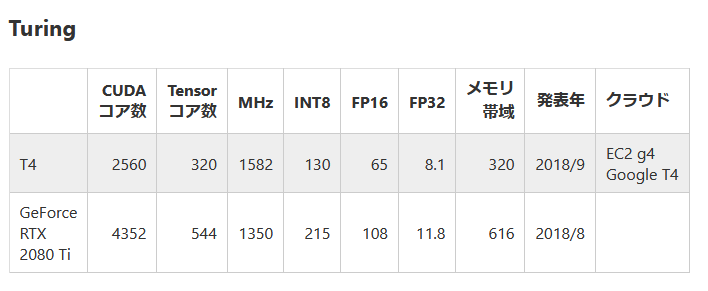)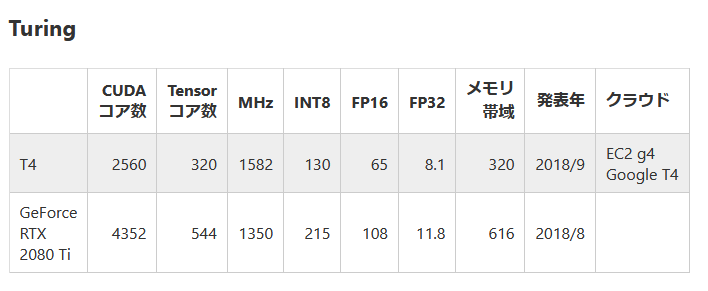

単位はTFLOPS（全て行列積）。メモリ帯域の単位はGB/s。

2019年よりTeslaという名称は消した。NVIDIA Tesla V100 → NVIDIA V100。


https://qiita.com/yukoba/items/10d0ba3fb1d19a6ab6a5 より引用

In [0]:
# Google Drive の マウント
from google.colab import drive
drive.mount('/content/drive')

In [0]:
! ls "/content/drive/My Drive/Colab Notebooks/database"

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

In [0]:
import pandas as pd

In [0]:
df_raw = pd.read_csv("/content/drive/My Drive/Colab Notebooks/database/jz7b02203_si_002.xlsx - perovskite.csv")

In [0]:
df_raw.tail()

In [0]:
df_raw.describe()

In [0]:
! pip install matminer

In [0]:
from pymatgen import Composition
from matminer.featurizers.composition import ElementProperty

In [0]:
# #
# features = ["Number", "MendeleevNumber", "AtomicWeight",
#              "MeltingT",
#              "Column", "Row", "CovalentRadius",
#              "Electronegativity", "NsValence", "NpValence",
#              "NdValence", "NfValence", "NValence",
#              "NsUnfilled", "NpUnfilled", "NdUnfilled", "NfUnfilled",
#              "NUnfilled", "GSvolume_pa",
#              "GSbandgap", "GSmagmom", "SpaceGroupNumber"]
# stats = ["minimum", "maximum", "range", "mean", "avg_dev", "mode"]
#
features = ["Number", "AtomicWeight",
             "MeltingT",
             "Column", "Row", "CovalentRadius",
             "Electronegativity", "NValence", "NUnfilled", "GSvolume_pa"]
stats = ["minimum", "maximum", "mean", "avg_dev"]
#
# features = ["Number", "AtomicWeight", "CovalentRadius", "Electronegativity"]
# stats = ["mean"]

featurizer = ElementProperty("magpie", features, stats)

In [0]:
df_raw["System"][0]

In [0]:
Composition(df_raw["System"][0])

In [0]:
[Composition(x) for x in df_raw["System"]]

In [0]:
[x * 2 for x in [1,2,3,4,5]]

In [0]:
df_features = pd.DataFrame(
    data=featurizer.featurize_many([Composition(x) for x in df_raw["System"]]), 
    columns=featurizer.feature_labels())

In [0]:
df_features.tail()

In [0]:
df_features.describe()

In [0]:
df_raw.columns

In [0]:
df = pd.concat([df_features, df_raw], axis=1)

In [0]:
df.columns

In [0]:
df.describe()

In [0]:
dataset = df[list(df_features.columns) + ["LowGap_SOHSE_Approx"]]

In [0]:
dataset.pop("MagpieData minimum NValence")
dataset.pop("MagpieData minimum Column")
dataset.pop("MagpieData maximum Column");

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

In [0]:
dataset.describe()

In [0]:
# データクレンジング

In [0]:
# 欠損値のチェック
dataset.isna().sum()

In [0]:
# 欠損の削除
dataset = dataset.dropna()

In [0]:
# 訓練用セットとテスト用セットに分割
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [0]:
# データの観察
#sns.pairplot(train_dataset, diag_kind="kde")

In [0]:
# 統計値の確認
train_stats = train_dataset.describe()
train_stats.pop("LowGap_SOHSE_Approx")
train_stats = train_stats.transpose()
train_stats

In [0]:
# ラベル（予測したい数量）と特徴量の分離
train_labels = train_dataset.pop('LowGap_SOHSE_Approx')
test_labels = test_dataset.pop('LowGap_SOHSE_Approx')

In [0]:
# データの正規化
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [0]:
normed_train_data.describe()

In [0]:
# モデルの構築
def build_model():
  model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [0]:
model = build_model()

In [0]:
# モデルの概要
model.summary()

In [0]:
# モデルの訓練
# エポックが終わるごとにドットを一つ出力することで進捗を表示
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

import time
a = time.time()
history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  batch_size=32,
  callbacks=[PrintDot()])
print('')
print("学習時間(s): ", time.time() - a)

In [0]:
# 訓練の様子
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [0]:
# 訓練の推移のプロット
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [eV]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,1])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$eV^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,1])
  plt.legend()
  plt.show()


plot_history(history)

In [0]:
model = build_model()

# patience は改善が見られるかを監視するエポック数を表すパラメーター
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [0]:
# テスト用データセットを使い、モデルの汎化をチェック
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} eV".format(mae))

In [0]:
# モデルを使った予測
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [eV]')
plt.ylabel('Predictions [eV]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

In [0]:
import numpy as np
import matplotlib.cm as cm

plt.hist2d(test_labels, test_predictions, range=[[0,6],[0,6]], bins=20, cmap=cm.jet)
plt.xlabel('True Values [eV]')
plt.ylabel('Predictions [eV]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

In [0]:
# 誤差の分布
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [eV]")
_ = plt.ylabel("Count")

サンプル数が多いと正規分布に近づくと考えられる